In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgbm
import optuna

c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#my function to check intersections and differences between sets of items
def check_sets(df1, col1, df2, col2, name1='first', name2='second'):
    set1 = set(df1[col1].unique())
    set2 = set(df2[col2].unique())
    print('in both files:', len(set1 & set2))
    print(f'in {name1} but not in {name2}:', len(set1 - set2))
    print(f'in {name2} but not in {name1}:', len(set2 - set1))

In [3]:
#read file
sales = pd.read_csv('sales_df_train.csv')
sales.head()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0,4.0,0.0,196.0,0.0
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0,1.0,0.0,78.0,0.0
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1,0.0,0.0,69.0,69.0
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0,1.0,0.0,161.0,0.0


In [4]:
sales.shape

(883015, 8)

In [5]:
#drop 2 inactive stores
sales = sales[~sales['st_id'].isin(['1aa057313c28fa4a40c5bc084b11d276', '62f91ce9b820a491ee78c108636db089'])]
sales.shape

(882286, 8)

In [6]:
#estimate cases where sales in units are zero and in rubles not, or vice versa
zero_nonzero_sales = sales[((sales['pr_sales_in_units'] != 0) & (sales['pr_sales_in_rub'] == 0)) | ((sales['pr_sales_in_units'] == 0) & (sales['pr_sales_in_rub'] != 0))]
zero_nonzero_sales.shape

(66882, 8)

In [7]:
#drop cases where sales in units are zero and in rubles not, or vice versa
sales = sales[((sales['pr_sales_in_units'] != 0) & (sales['pr_sales_in_rub'] != 0)) | ((sales['pr_sales_in_units'] == 0) & (sales['pr_sales_in_rub'] == 0))]
sales.shape

(815404, 8)

In [8]:
#drop negative sales
sales = sales[(sales['pr_sales_in_rub'] >= 0) & (sales['pr_sales_in_units'] >= 0) & (sales['pr_promo_sales_in_rub'] >= 0) & (sales['pr_promo_sales_in_units'] >= 0)]
sales.shape

(815334, 8)

In [9]:
#concat item-store pair into single unit
sales['store_item'] = sales['st_id'].str.cat(sales['pr_sku_id'], sep='-')
sales['store_item'].nunique()

6130

In [37]:
#glue together promo and non-promo sales of one item-store pair on same day
oneline = sales.groupby(['store_item', 'date'])[['pr_sales_type_id', 'pr_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_units', 'pr_promo_sales_in_rub']].sum()
oneline.shape

(661192, 5)

In [38]:
#detect top150 item-store pairs
by_pair = oneline.groupby('store_item')[['pr_sales_in_units', 'pr_sales_in_rub']].agg(['sum', 'count'])
all_sales = by_pair[('pr_sales_in_rub', 'sum')].sum()
by_pair['all_sales_share'] = by_pair[('pr_sales_in_rub', 'sum')] / all_sales * 100
by_pair.sort_values([('pr_sales_in_units', 'sum')], ascending=False).head(150)

pr_sales_in_units        \
                                                                 sum count   
store_item                                                                   
16a5cdae362b8d27a1d8f8c7b78b4330-62d4af457ba254...           51500.0   352   
c81e728d9d4c2f636f067f89cc14862c-20d9b4bfd4b672...           42088.0   278   
42a0e188f5033bc65bf8d78622277c4e-ced0c1a84924c9...           34255.0   352   
fa7cdfad1a5aaf8370ebeda47a1ff1c3-c0e3f3bd815a86...           32923.0   352   
16a5cdae362b8d27a1d8f8c7b78b4330-ced0c1a84924c9...           29678.0   352   
...                                                              ...   ...   
f7e6c85504ce6e82442c770f7c8606f0-7a5ebc8af26893...            5469.0   345   
c81e728d9d4c2f636f067f89cc14862c-5b26f85ccb2303...            5417.0   352   
42a0e188f5033bc65bf8d78622277c4e-603c32f40317b3...            5399.0   339   
42a0e188f5033bc65bf8d78622277c4e-d22bb534b7964c...            5364.0   351   
f7e6c85504ce6e82442c770f7c8606f0-2d4cee78441933...            5337.0   192   

                                                   pr_sales_in_rub        \
                                                               sum count   
store_item                                                                 
16a5cdae362b8d27a1d8f8c7b78b4330-62d4af457ba254...        879274.0   352   
c81e728d9d4c2f636f067f89cc14862c-20d9b4bfd4b672...       1999391.0   278   
42a0e188f5033bc65bf8d78622277c4e-ced0c1a84924c9...       1070819.0   352   
fa7cdfad1a5aaf8370ebeda47a1ff1c3-c0e3f3bd815a86...       4187731.0   352   
16a5cdae362b8d27a1d8f8c7b78b4330-ced0c1a84924c9...        963222.0   352   
...                                                            ...   ...   
f7e6c85504ce6e82442c770f7c8606f0-7a5ebc8af26893...        324306.0   345   
c81e728d9d4c2f636f067f89cc14862c-5b26f85ccb2303...         84293.0   352   
42a0e188f5033bc65bf8d78622277c4e-603c32f40317b3...        643395.0   339   
42a0e188f5033bc65bf8d78622277c4e-d22bb534b7964c...        328648.0   351   
f7e6c85504ce6e82442c770f7c8606f0-2d4cee78441933...        913631.0   192   

                                                   all_sales_share  
                                                                    
store_item                                                          
16a5cdae362b8d27a1d8f8c7b78b4330-62d4af457ba254...        0.168569  
c81e728d9d4c2f636f067f89cc14862c-20d9b4bfd4b672...        0.383311  
42a0e188f5033bc65bf8d78622277c4e-ced0c1a84924c9...        0.205291  
fa7cdfad1a5aaf8370ebeda47a1ff1c3-c0e3f3bd815a86...        0.802847  
16a5cdae362b8d27a1d8f8c7b78b4330-ced0c1a84924c9...        0.184663  
...                                                            ...  
f7e6c85504ce6e82442c770f7c8606f0-7a5ebc8af26893...        0.062174  
c81e728d9d4c2f636f067f89cc14862c-5b26f85ccb2303...        0.016160  
42a0e188f5033bc65bf8d78622277c4e-603c32f40317b3...        0.123348  
42a0e188f5033bc65bf8d78622277c4e-d22bb534b7964c...        0.063006  
f7e6c85504ce6e82442c770f7c8606f0-2d4cee78441933...        0.175156  

[150 rows x 5 columns]

In [39]:
#separate top 150
by_pair = by_pair.reset_index()
top150 = by_pair.sort_values([('pr_sales_in_units', 'sum')], ascending=False).head(150)
no_top150 = by_pair[~by_pair['store_item'].isin(top150['store_item'])]
most_frequent = no_top150[no_top150[('pr_sales_in_units', 'count')] >= 352*0.8]
flagman = pd.concat([top150, most_frequent])
flagman.shape

(857, 6)

In [40]:
#get no flagman pairs
rest = by_pair[~by_pair['store_item'].isin(flagman['store_item'])]
rest.shape

(5273, 6)

In [41]:
oneline = oneline.reset_index()
oneline.head()

,store_item,date,pr_sales_type_id,pr_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_units,pr_promo_sales_in_rub
0,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-04-07,1,1.0,81.0,1.0,81.0
1,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-04-11,1,1.0,81.0,1.0,81.0
2,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-04-12,1,1.0,81.0,1.0,81.0
3,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-04-29,0,1.0,146.0,0.0,0.0
4,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-05-24,0,1.0,146.0,0.0,0.0


In [42]:
#make train dataset out of top50 and their sales
train = oneline[oneline['store_item'].isin(rest['store_item'])]
train.shape

(387062, 7)

In [45]:
#i suppose in this set we should separate store from item
separate_product_store = sales[['pr_sku_id', 'st_id', 'store_item']].drop_duplicates(subset='store_item')
separate_product_store.shape

(6130, 3)

In [46]:
train = train.merge(separate_product_store, how='left', on='store_item')
train = train[['pr_sku_id', 'st_id', 'date', 'pr_sales_in_units']]
train.shape

(387062, 4)

In [47]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387062 entries, 0 to 387061
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pr_sku_id          387062 non-null  object 
 1   st_id              387062 non-null  object 
 2   date               387062 non-null  object 
 3   pr_sales_in_units  387062 non-null  float64
dtypes: float64(1), object(3)
memory usage: 11.8+ MB


In [48]:
train['date'] = pd.to_datetime(train['date']).dt.normalize()

In [49]:
train['date'].describe()

count                           387062
mean     2023-01-25 10:16:32.027116800
min                2022-08-01 00:00:00
25%                2022-10-28 00:00:00
50%                2023-01-26 00:00:00
75%                2023-04-26 00:00:00
max                2023-07-18 00:00:00
Name: date, dtype: object

In [94]:
#and this full set we shall use to get lags by product. separate store from item and format date
byproduct = oneline.groupby(['store_item', 'date'])['pr_sales_in_units'].sum().reset_index()
byproduct = byproduct.merge(separate_product_store, how='left', on='store_item')
byproduct = byproduct[['pr_sku_id', 'st_id', 'date', 'pr_sales_in_units']]
byproduct['date'] = pd.to_datetime(byproduct['date']).dt.normalize()
byproduct.head()

,pr_sku_id,st_id,date,pr_sales_in_units
0,0376a60d9a7ce7965beddc4815588697,084a8a9aa8cced9175bd07bc44998e75,2023-04-07,1.0
1,0376a60d9a7ce7965beddc4815588697,084a8a9aa8cced9175bd07bc44998e75,2023-04-11,1.0
2,0376a60d9a7ce7965beddc4815588697,084a8a9aa8cced9175bd07bc44998e75,2023-04-12,1.0
3,0376a60d9a7ce7965beddc4815588697,084a8a9aa8cced9175bd07bc44998e75,2023-04-29,1.0
4,0376a60d9a7ce7965beddc4815588697,084a8a9aa8cced9175bd07bc44998e75,2023-05-24,1.0


In [95]:
#check shape - its the shape of the full sales set after we glued together promo and non-promo for the same day
byproduct.shape

(661192, 4)

In [96]:
#sales of one product in all stores by day
byproduct = byproduct.groupby(['pr_sku_id', 'date'])['pr_sales_in_units'].sum().reset_index()
byproduct.shape

(277472, 3)

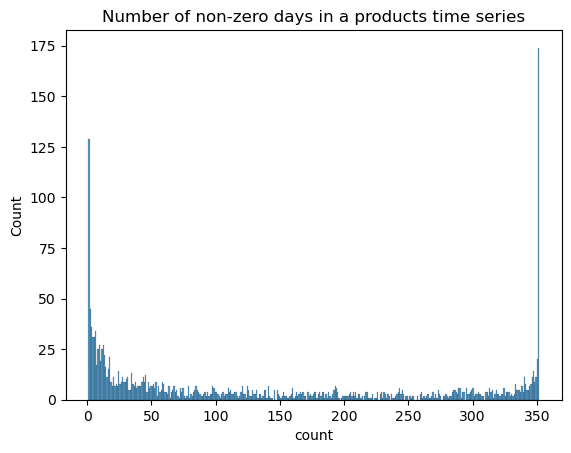

In [97]:
series_density = byproduct['pr_sku_id'].value_counts()
sns.histplot(series_density, bins=350)
plt.title('Number of non-zero days in a products time series');

Очень много товаров продавалось всего один день. Вообще разреженные временные ряды преобладают. Сейчас мы достроим их нулями и получим очень много нулей (но не так много, как если бы единицей моделирования оставался товар-магазин)

In [98]:
#number of unique products
byproduct['pr_sku_id'].nunique()

1973

In [99]:
#insert zeros for missing dates
byproduct = byproduct.sort_values(by='date')
bypr_pivoted = byproduct.pivot(index='pr_sku_id', columns='date', values='pr_sales_in_units').fillna(0)

bypr_long = bypr_pivoted.stack().reset_index()
bypr_long = bypr_long.rename(columns={'level_1': 'date', 0: 'sku'})
bypr_long.head()

,pr_sku_id,date,sku
0,002c3a40ac50dc870f1ff386f11f5bae,2022-08-01,0.0
1,002c3a40ac50dc870f1ff386f11f5bae,2022-08-02,0.0
2,002c3a40ac50dc870f1ff386f11f5bae,2022-08-03,0.0
3,002c3a40ac50dc870f1ff386f11f5bae,2022-08-04,0.0
4,002c3a40ac50dc870f1ff386f11f5bae,2022-08-05,0.0


In [100]:
#assert number of lines equals 1973 items * 352 days
bypr_long.shape, 1973*352

((694496, 3), 694496)

In [102]:
#add lag columns
shifted = bypr_long.set_index(['pr_sku_id', 'date'])
new = shifted.copy()

for i in range(21):
    shifted_i = shifted.groupby(level="pr_sku_id").shift(i+1)
    new = new.join(shifted_i.rename(columns=lambda x: x+f"_lag_{i+1}"))
new.head()

sku  sku_lag_1  sku_lag_2  \
pr_sku_id                        date                                    
002c3a40ac50dc870f1ff386f11f5bae 2022-08-01  0.0        NaN        NaN   
                                 2022-08-02  0.0        0.0        NaN   
                                 2022-08-03  0.0        0.0        0.0   
                                 2022-08-04  0.0        0.0        0.0   
                                 2022-08-05  0.0        0.0        0.0   

                                             sku_lag_3  sku_lag_4  sku_lag_5  \
pr_sku_id                        date                                          
002c3a40ac50dc870f1ff386f11f5bae 2022-08-01        NaN        NaN        NaN   
                                 2022-08-02        NaN        NaN        NaN   
                                 2022-08-03        NaN        NaN        NaN   
                                 2022-08-04        0.0        NaN        NaN   
                                 2022-08-05        0.0        0.0        NaN   

                                             sku_lag_6  sku_lag_7  sku_lag_8  \
pr_sku_id                        date                                          
002c3a40ac50dc870f1ff386f11f5bae 2022-08-01        NaN        NaN        NaN   
                                 2022-08-02        NaN        NaN        NaN   
                                 2022-08-03        NaN        NaN        NaN   
                                 2022-08-04        NaN        NaN        NaN   
                                 2022-08-05        NaN        NaN        NaN   

                                             sku_lag_9  ...  sku_lag_12  \
pr_sku_id                        date                   ...               
002c3a40ac50dc870f1ff386f11f5bae 2022-08-01        NaN  ...         NaN   
                                 2022-08-02        NaN  ...         NaN   
                                 2022-08-03        NaN  ...         NaN   
                                 2022-08-04        NaN  ...         NaN   
                                 2022-08-05        NaN  ...         NaN   

                                             sku_lag_13  sku_lag_14  \
pr_sku_id                        date                                 
002c3a40ac50dc870f1ff386f11f5bae 2022-08-01         NaN         NaN   
                                 2022-08-02         NaN         NaN   
                                 2022-08-03         NaN         NaN   
                                 2022-08-04         NaN         NaN   
                                 2022-08-05         NaN         NaN   

                                             sku_lag_15  sku_lag_16  \
pr_sku_id                        date                                 
002c3a40ac50dc870f1ff386f11f5bae 2022-08-01         NaN         NaN   
                                 2022-08-02         NaN         NaN   
                                 2022-08-03         NaN         NaN   
                                 2022-08-04         NaN         NaN   
                                 2022-08-05         NaN         NaN   

                                             sku_lag_17  sku_lag_18  \
pr_sku_id                        date                                 
002c3a40ac50dc870f1ff386f11f5bae 2022-08-01         NaN         NaN   
                                 2022-08-02         NaN         NaN   
                                 2022-08-03         NaN         NaN   
                                 2022-08-04         NaN         NaN   
                                 2022-08-05         NaN         NaN   

                                             sku_lag_19  sku_lag_20  \
pr_sku_id                        date                                 
002c3a40ac50dc870f1ff386f11f5bae 2022-08-01         NaN         NaN   
                                 2022-08-02         NaN         NaN   
                                 2022-08-03         NaN         NaN   
                             

In [103]:
#delete nans where there's no lag data (start of period)
new['na_sum'] = new.isna().sum(axis=1)
new = new[new['na_sum'] == 0]
new = new.drop('na_sum', axis=1)
new.shape

(653063, 22)

In [104]:
#look at the edge between units to make sure lags don't mix up
new[659:666]

sku  sku_lag_1  sku_lag_2  \
pr_sku_id                        date                                    
0045ebdb1069ff4b3dd3efe628c39cd3 2023-07-16  2.0        3.0        4.0   
                                 2023-07-17  3.0        2.0        3.0   
                                 2023-07-18  3.0        3.0        2.0   
005c52de11abaf8e0a9714b24415ce34 2022-08-22  0.0        0.0        0.0   
                                 2022-08-23  0.0        0.0        0.0   
                                 2022-08-24  0.0        0.0        0.0   
                                 2022-08-25  0.0        0.0        0.0   

                                             sku_lag_3  sku_lag_4  sku_lag_5  \
pr_sku_id                        date                                          
0045ebdb1069ff4b3dd3efe628c39cd3 2023-07-16        1.0        0.0        0.0   
                                 2023-07-17        4.0        1.0        0.0   
                                 2023-07-18        3.0        4.0        1.0   
005c52de11abaf8e0a9714b24415ce34 2022-08-22        0.0        0.0        0.0   
                                 2022-08-23        0.0        0.0        0.0   
                                 2022-08-24        0.0        0.0        0.0   
                                 2022-08-25        0.0        0.0        0.0   

                                             sku_lag_6  sku_lag_7  sku_lag_8  \
pr_sku_id                        date                                          
0045ebdb1069ff4b3dd3efe628c39cd3 2023-07-16        0.0        0.0        0.0   
                                 2023-07-17        0.0        0.0        0.0   
                                 2023-07-18        0.0        0.0        0.0   
005c52de11abaf8e0a9714b24415ce34 2022-08-22        0.0        0.0        0.0   
                                 2022-08-23        0.0        0.0        0.0   
                                 2022-08-24        0.0        0.0        0.0   
                                 2022-08-25        0.0        0.0        0.0   

                                             sku_lag_9  ...  sku_lag_12  \
pr_sku_id                        date                   ...               
0045ebdb1069ff4b3dd3efe628c39cd3 2023-07-16        0.0  ...         0.0   
                                 2023-07-17        0.0  ...         0.0   
                                 2023-07-18        0.0  ...         0.0   
005c52de11abaf8e0a9714b24415ce34 2022-08-22        0.0  ...         0.0   
                                 2022-08-23        0.0  ...         0.0   
                                 2022-08-24        0.0  ...         0.0   
                                 2022-08-25        0.0  ...         0.0   

                                             sku_lag_13  sku_lag_14  \
pr_sku_id                        date                                 
0045ebdb1069ff4b3dd3efe628c39cd3 2023-07-16         0.0         0.0   
                                 2023-07-17         0.0         0.0   
                                 2023-07-18         0.0         0.0   
005c52de11abaf8e0a9714b24415ce34 2022-08-22         0.0         0.0   
                                 2022-08-23         0.0         0.0   
                                 2022-08-24         0.0         0.0   
                                 2022-08-25         0.0         0.0   

                                             sku_lag_15  sku_lag_16  \
pr_sku_id                        date                                 
0045ebdb1069ff4b3dd3efe628c39cd3 2023-07-16         0.0         0.0   
                                 2023-07-17         0.0         0.0   
                                 2023-07-18         0.0         0.0   
005c52de11abaf8e0a9714b24415ce34 2022-08-22         0.0         0.0   
                                 2022-08-23         0.0         0.0   
                                 2022-08-24         0.0         0.0   
                                 2022-08-25         

In [105]:
new = new.reset_index()
new['date']

0        2022-08-22
1        2022-08-23
2        2022-08-24
3        2022-08-25
4        2022-08-26
            ...    
653058   2023-07-14
653059   2023-07-15
653060   2023-07-16
653061   2023-07-17
653062   2023-07-18
Name: date, Length: 653063, dtype: datetime64[ns]

In [106]:
#get back to the name byproduct and drop sku column as it's a leak
byproduct = new.drop('sku', axis=1)

In [107]:
#get new sold column, it's target
train = train.rename(columns={'pr_sales_in_units': 'sold'})
train.shape

(387062, 4)

In [108]:
#add lags. remember thei're not for store-item but for item in all stores that day
with_lags = train.merge(byproduct, on=['pr_sku_id', 'date'], how='left')
with_lags.shape

(387062, 25)

In [113]:
#lets get lags by store
bystore = oneline.groupby(['store_item', 'date'])['pr_sales_in_units'].sum().reset_index()
bystore = bystore.merge(separate_product_store, how='left', on='store_item')
bystore = bystore[['pr_sku_id', 'st_id', 'date', 'pr_sales_in_units']]
bystore['date'] = pd.to_datetime(bystore['date']).dt.normalize()
bystore.head()

,pr_sku_id,st_id,date,pr_sales_in_units
0,0376a60d9a7ce7965beddc4815588697,084a8a9aa8cced9175bd07bc44998e75,2023-04-07,1.0
1,0376a60d9a7ce7965beddc4815588697,084a8a9aa8cced9175bd07bc44998e75,2023-04-11,1.0
2,0376a60d9a7ce7965beddc4815588697,084a8a9aa8cced9175bd07bc44998e75,2023-04-12,1.0
3,0376a60d9a7ce7965beddc4815588697,084a8a9aa8cced9175bd07bc44998e75,2023-04-29,1.0
4,0376a60d9a7ce7965beddc4815588697,084a8a9aa8cced9175bd07bc44998e75,2023-05-24,1.0


In [114]:
#sales in every store by day
bystore = bystore.groupby(['st_id', 'date'])['pr_sales_in_units'].sum().reset_index()
bystore.shape

(3156, 3)

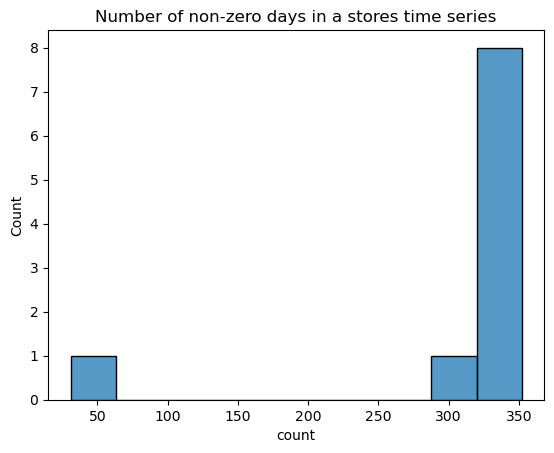

In [116]:
series_density = bystore['st_id'].value_counts()
sns.histplot(series_density, bins=10)
plt.title('Number of non-zero days in a stores time series');

В одном магазине очень мало активных дней, в одном - почти все, в 8 магазинах - во все дни есть продажи

In [117]:
bystore['st_id'].value_counts().sort_values()

st_id
084a8a9aa8cced9175bd07bc44998e75     31
bd470ca955d9497bbcb808e59952fffc    309
16a5cdae362b8d27a1d8f8c7b78b4330    352
1ecfb463472ec9115b10c292ef8bc986    352
42a0e188f5033bc65bf8d78622277c4e    352
53e19f3dbb211f20b20b45668303c1b6    352
6364d3f0f495b6ab9dcf8d3b5c6e0b01    352
c81e728d9d4c2f636f067f89cc14862c    352
f7e6c85504ce6e82442c770f7c8606f0    352
fa7cdfad1a5aaf8370ebeda47a1ff1c3    352
Name: count, dtype: int64

In [118]:
bystore[bystore['st_id'] == '084a8a9aa8cced9175bd07bc44998e75']

,st_id,date,pr_sales_in_units
0,084a8a9aa8cced9175bd07bc44998e75,2023-03-26,3.0
1,084a8a9aa8cced9175bd07bc44998e75,2023-03-27,1.0
2,084a8a9aa8cced9175bd07bc44998e75,2023-03-30,3.0
3,084a8a9aa8cced9175bd07bc44998e75,2023-04-01,3.0
4,084a8a9aa8cced9175bd07bc44998e75,2023-04-02,2.0
5,084a8a9aa8cced9175bd07bc44998e75,2023-04-04,2.0
6,084a8a9aa8cced9175bd07bc44998e75,2023-04-06,1.0
7,084a8a9aa8cced9175bd07bc44998e75,2023-04-07,3.0
8,084a8a9aa8cced9175bd07bc44998e75,2023-04-10,1.0
9,084a8a9aa8cced9175bd07bc44998e75,2023-04-11,2.0


In [119]:
sample_sub = pd.read_csv('sales_submission.csv')
sample_sub[sample_sub['st_id'] == '084a8a9aa8cced9175bd07bc44998e75']

,st_id,pr_sku_id,date,target


В сабмите этого магазина нет, продажи маленькие и закончились какое-то время назад. Можно его удалить, но я оставлю для общих сумм, раз не удалила сразу. Я думаю, цифры слишком маленькие, чтобы на что-то влиять

In [123]:
#insert zeros for missing dates
bystore = bystore.sort_values(by='date')
byst_pivoted = bystore.pivot(index='st_id', columns='date', values='pr_sales_in_units').fillna(0)

byst_long = byst_pivoted.stack().reset_index()
byst_long = byst_long.rename(columns={'level_1': 'date', 0: 'store'})
byst_long.head()

,st_id,date,store
0,084a8a9aa8cced9175bd07bc44998e75,2022-08-01,0.0
1,084a8a9aa8cced9175bd07bc44998e75,2022-08-02,0.0
2,084a8a9aa8cced9175bd07bc44998e75,2022-08-03,0.0
3,084a8a9aa8cced9175bd07bc44998e75,2022-08-04,0.0
4,084a8a9aa8cced9175bd07bc44998e75,2022-08-05,0.0


In [124]:
#assert number of lines equals 10 stores * 352 days
byst_long.shape, 10*352

((3520, 3), 3520)

In [125]:
#add lag columns
shifted = byst_long.set_index(['st_id', 'date'])
new = shifted.copy()

for i in range(21):
    shifted_i = shifted.groupby(level="st_id").shift(i+1)
    new = new.join(shifted_i.rename(columns=lambda x: x+f"_lag_{i+1}"))
new.head()

store  store_lag_1  store_lag_2  \
st_id                            date                                          
084a8a9aa8cced9175bd07bc44998e75 2022-08-01    0.0          NaN          NaN   
                                 2022-08-02    0.0          0.0          NaN   
                                 2022-08-03    0.0          0.0          0.0   
                                 2022-08-04    0.0          0.0          0.0   
                                 2022-08-05    0.0          0.0          0.0   

                                             store_lag_3  store_lag_4  \
st_id                            date                                   
084a8a9aa8cced9175bd07bc44998e75 2022-08-01          NaN          NaN   
                                 2022-08-02          NaN          NaN   
                                 2022-08-03          NaN          NaN   
                                 2022-08-04          0.0          NaN   
                                 2022-08-05          0.0          0.0   

                                             store_lag_5  store_lag_6  \
st_id                            date                                   
084a8a9aa8cced9175bd07bc44998e75 2022-08-01          NaN          NaN   
                                 2022-08-02          NaN          NaN   
                                 2022-08-03          NaN          NaN   
                                 2022-08-04          NaN          NaN   
                                 2022-08-05          NaN          NaN   

                                             store_lag_7  store_lag_8  \
st_id                            date                                   
084a8a9aa8cced9175bd07bc44998e75 2022-08-01          NaN          NaN   
                                 2022-08-02          NaN          NaN   
                                 2022-08-03          NaN          NaN   
                                 2022-08-04          NaN          NaN   
                                 2022-08-05          NaN          NaN   

                                             store_lag_9  ...  store_lag_12  \
st_id                            date                     ...                 
084a8a9aa8cced9175bd07bc44998e75 2022-08-01          NaN  ...           NaN   
                                 2022-08-02          NaN  ...           NaN   
                                 2022-08-03          NaN  ...           NaN   
                                 2022-08-04          NaN  ...           NaN   
                                 2022-08-05          NaN  ...           NaN   

                                             store_lag_13  store_lag_14  \
st_id                            date                                     
084a8a9aa8cced9175bd07bc44998e75 2022-08-01           NaN           NaN   
                                 2022-08-02           NaN           NaN   
                                 2022-08-03           NaN           NaN   
                                 2022-08-04           NaN           NaN   
                                 2022-08-05           NaN           NaN   

                                             store_lag_15  store_lag_16  \
st_id                            date                                     
084a8a9aa8cced9175bd07bc44998e75 2022-08-01           NaN           NaN   
                                 2022-08-02           NaN           NaN   
                                 2022-08-03           NaN           NaN   
                                 2022-08-04           NaN           NaN   
                                 2022-08-05           NaN           NaN   

                                             store_lag_17  store_lag_18  \
st_id                            date                                     
084a8a9aa8cced9175bd07bc44998e75 2022-08-01           NaN           NaN   
                                 2022-08-02           NaN           NaN   
                                 2022-08-0

In [126]:
#delete nans where there's no lag data (start of period)
new['na_sum'] = new.isna().sum(axis=1)
new = new[new['na_sum'] == 0]
new = new.drop('na_sum', axis=1)
new.shape

(3310, 22)

In [127]:
#look at the edge between units to make sure lags don't mix up
new[659:666]

store  store_lag_1  store_lag_2  \
st_id                            date                                           
16a5cdae362b8d27a1d8f8c7b78b4330 2023-07-16  2688.0       3690.0       3837.0   
                                 2023-07-17  1810.0       2688.0       3690.0   
                                 2023-07-18  2161.0       1810.0       2688.0   
1ecfb463472ec9115b10c292ef8bc986 2022-08-22   427.0        263.0        337.0   
                                 2022-08-23   485.0        427.0        263.0   
                                 2022-08-24   469.0        485.0        427.0   
                                 2022-08-25   402.0        469.0        485.0   

                                             store_lag_3  store_lag_4  \
st_id                            date                                   
16a5cdae362b8d27a1d8f8c7b78b4330 2023-07-16       3074.0       2053.0   
                                 2023-07-17       3837.0       3074.0   
                                 2023-07-18       3690.0       3837.0   
1ecfb463472ec9115b10c292ef8bc986 2022-08-22        527.0        577.0   
                                 2022-08-23        337.0        527.0   
                                 2022-08-24        263.0        337.0   
                                 2022-08-25        427.0        263.0   

                                             store_lag_5  store_lag_6  \
st_id                            date                                   
16a5cdae362b8d27a1d8f8c7b78b4330 2023-07-16       2132.0       2049.0   
                                 2023-07-17       2053.0       2132.0   
                                 2023-07-18       3074.0       2053.0   
1ecfb463472ec9115b10c292ef8bc986 2022-08-22        401.0        376.0   
                                 2022-08-23        577.0        401.0   
                                 2022-08-24        527.0        577.0   
                                 2022-08-25        337.0        527.0   

                                             store_lag_7  store_lag_8  \
st_id                            date                                   
16a5cdae362b8d27a1d8f8c7b78b4330 2023-07-16       2443.0       3398.0   
                                 2023-07-17       2049.0       2443.0   
                                 2023-07-18       2132.0       2049.0   
1ecfb463472ec9115b10c292ef8bc986 2022-08-22        518.0        344.0   
                                 2022-08-23        376.0        518.0   
                                 2022-08-24        401.0        376.0   
                                 2022-08-25        577.0        401.0   

                                             store_lag_9  ...  store_lag_12  \
st_id                            date                     ...                 
16a5cdae362b8d27a1d8f8c7b78b4330 2023-07-16       3610.0  ...        2153.0   
                                 2023-07-17       3398.0  ...        2143.0   
                                 2023-07-18       2443.0  ...        2442.0   
1ecfb463472ec9115b10c292ef8bc986 2022-08-22        332.0  ...         410.0   
                                 2022-08-23        344.0  ...         341.0   
                                 2022-08-24        518.0  ...         407.0   
                                 2022-08-25        376.0  ...         332.0   

                                             store_lag_13  store_lag_14  \
st_id                            date                                     
16a5cdae362b8d27a1d8f8c7b78b4330 2023-07-16        1873.0        2576.0   
                                 2023-07-17        2153.0        1873.0   
                                 2023-07-18        2143.0        2153.0   
1ecfb463472ec9115b10c292ef8bc986 2022-08-22         403.0         422.0   
                                 2022-08-23         410.0         403.0   
                                 2022-08-24         341.0         410.0   
                              

In [128]:
new = new.reset_index()
bystore = new.drop('store', axis=1)

In [130]:
#add store lags
with_store_lags = with_lags.merge(bystore, on=['st_id', 'date'], how='left')
with_store_lags.shape

(387062, 46)

### Modelling goes here

In [101]:
def wape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

In [109]:
def plotImp(model, X , num = 20, fig_size = (15, 5)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features importance')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

In [110]:
def lgbm_cross_val(cat_features, cols_to_drop, df=new, h=14, cv=5):
    wapes = []
    for i in range(cv):
        end_train = df['date'].max() - pd.Timedelta(days=h*(i+1))
        end_valid = df['date'].max() - pd.Timedelta(days=h*i)
        train = df[df['date'] <= end_train]
        valid = df[(df['date'] > end_train) & (df['date'] <= end_valid)]

        X_train = train.drop(cols_to_drop, axis=1)
        y_train = train['sold']
        X_valid = valid.drop(cols_to_drop, axis=1)
        y_valid = valid['sold']

        eval_set = [(X_valid, y_valid)]
        print(end_train, end_valid)
        print(X_train.shape, X_valid.shape)

        cat_idx = [X_train.columns.get_loc(col) for col in cat_features]

        for col in cat_features:
            X_train[col] = pd.Categorical(X_train[col])
            X_valid[col] = pd.Categorical(X_valid[col])


        lgbm_reg = lgbm.LGBMRegressor(n_estimators=10000, random_state=26)
        lgbm_reg.fit(
                X_train, 
                y_train,        
                categorical_feature=cat_idx,
                eval_set=eval_set,
                early_stopping_rounds=200,
                verbose=100
            )

        preds = lgbm_reg.predict(X_valid)
        lgbm_wape = wape(y_valid, preds)
        
        plot_df = pd.DataFrame({'date': pd.date_range(start=(end_train+pd.Timedelta(days=1)), end=end_valid), 'y_true': y_valid[:h], 'y_pred': preds[:h]})
        
        fig, ax = plt.subplots(figsize=(12, 3))
        g = sns.lineplot(data=plot_df)
        plt.title(f'CV step {i+1}')
        plt.show()        
        
        print(f"LGBM CV step {i+1} WAPE: {lgbm_wape}")
        wapes.append(lgbm_wape)

        
    plotImp(lgbm_reg, X_train)

    return(wapes)

2023-07-04 00:00:00 2023-07-18 00:00:00
(370307, 44) (16755, 44)


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[100]	valid_0's l2: 28.3289
[200]	valid_0's l2: 27.5578
[300]	valid_0's l2: 27.3863
[400]	valid_0's l2: 27.3073
[500]	valid_0's l2: 27.0358
[600]	valid_0's l2: 27.0781
[700]	valid_0's l2: 26.9592
[800]	valid_0's l2: 26.8646
[900]	valid_0's l2: 26.8393
[1000]	valid_0's l2: 26.9006


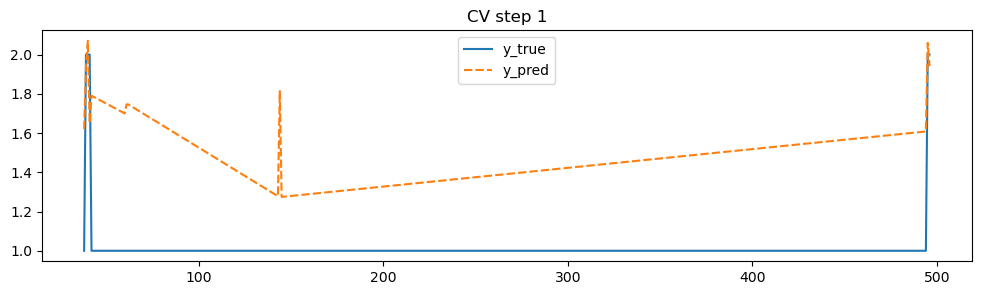

LGBM CV step 1 WAPE: 0.5097610575835853
2023-06-20 00:00:00 2023-07-04 00:00:00
(353739, 44) (16568, 44)


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[100]	valid_0's l2: 21.0118
[200]	valid_0's l2: 20.7496
[300]	valid_0's l2: 20.89
[400]	valid_0's l2: 20.9821


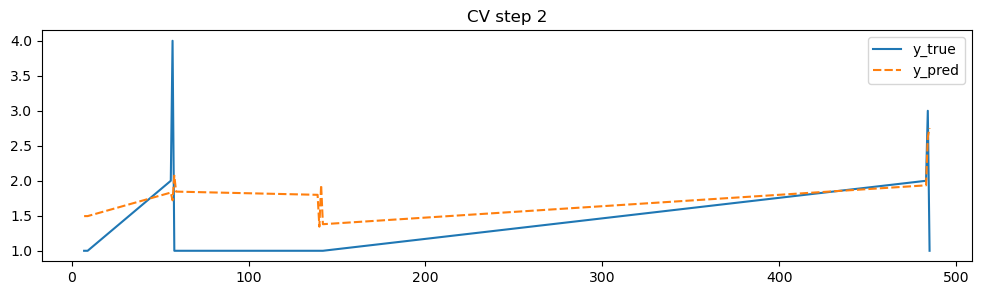

LGBM CV step 2 WAPE: 0.5251773023767188
2023-06-06 00:00:00 2023-06-20 00:00:00
(337483, 44) (16256, 44)


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[100]	valid_0's l2: 27.4058
[200]	valid_0's l2: 26.8565
[300]	valid_0's l2: 27.046
[400]	valid_0's l2: 27.1483


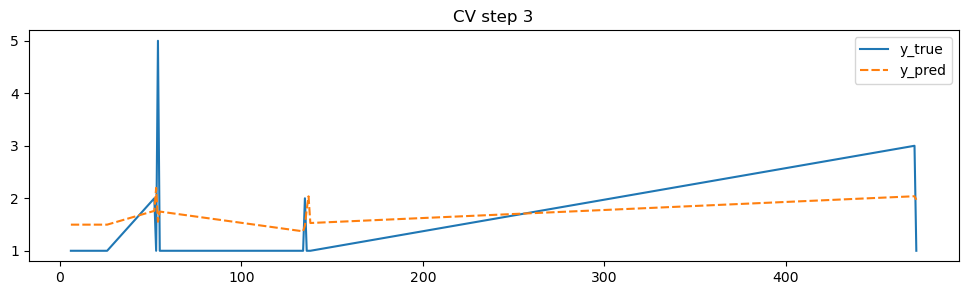

LGBM CV step 3 WAPE: 0.5283386652940149
2023-05-23 00:00:00 2023-06-06 00:00:00
(321717, 44) (15766, 44)


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[100]	valid_0's l2: 21.8839
[200]	valid_0's l2: 21.5449
[300]	valid_0's l2: 21.6055
[400]	valid_0's l2: 21.7007
[500]	valid_0's l2: 21.7966


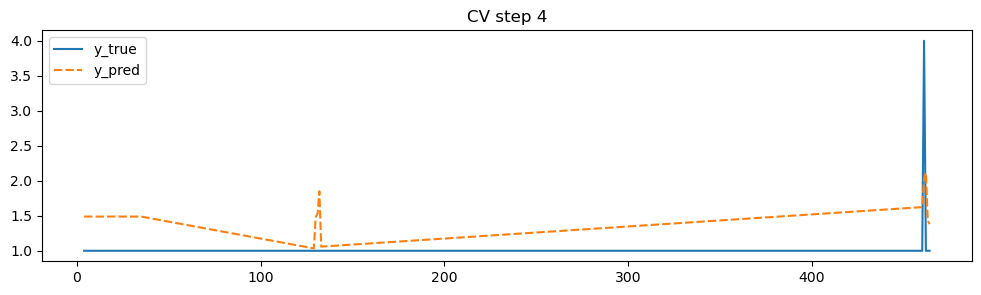

LGBM CV step 4 WAPE: 0.5287157300652112
2023-05-09 00:00:00 2023-05-23 00:00:00
(305868, 44) (15849, 44)


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[100]	valid_0's l2: 30.7057
[200]	valid_0's l2: 31.4078


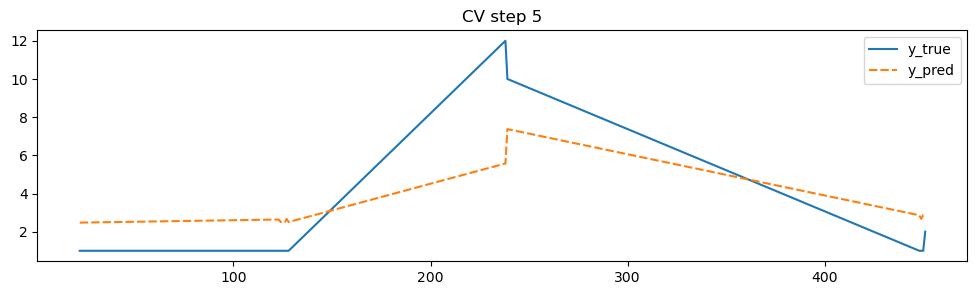

LGBM CV step 5 WAPE: 0.6229050869497751


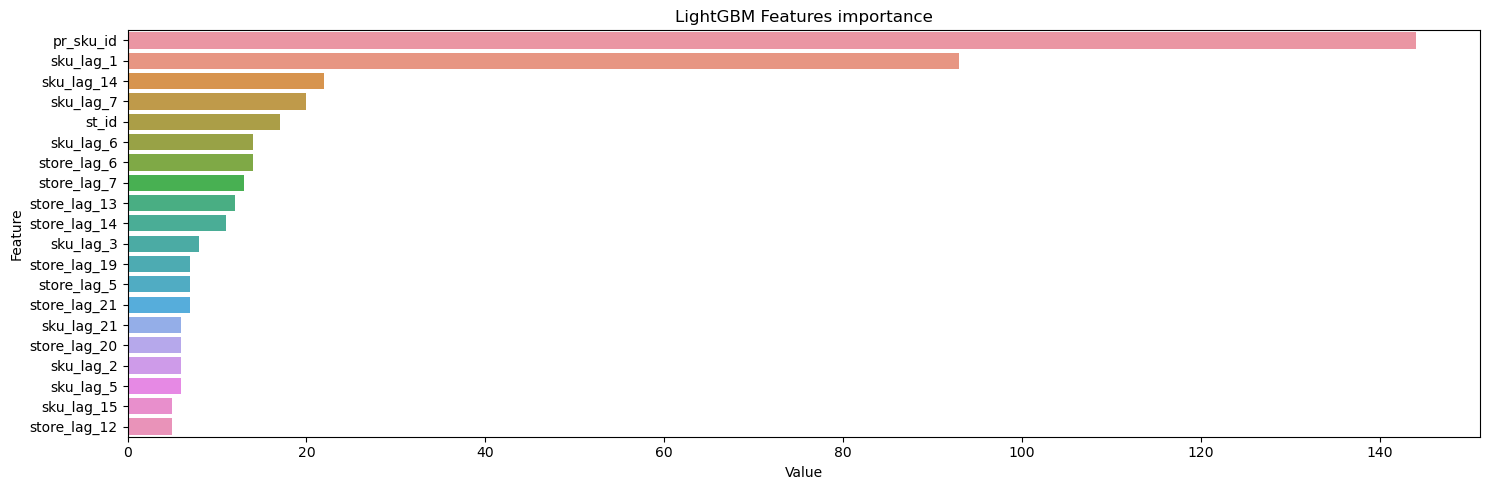

In [131]:
lgbm_wapes = lgbm_cross_val(df=with_store_lags, cat_features=['pr_sku_id', 'st_id'], cols_to_drop=['date', 'sold'])

In [132]:
print(f'LGBM mean WAPE = {np.mean(lgbm_wapes)}')

LGBM mean WAPE = 0.542979568453861


Итерация 1

* Фичи: товар, магазин, 21 лаг (Тлаг)
* ВЭЙП: 0.5387446485520166
* Важное: товар, Тлаг 1, магазин, Тлаги 14, 7, 2, 6, 12, 13, 5, 9

Итерация 2

* Фичи: товар, магазин, 21 лаг (Тлаг), 21 лаг (Млаг)
* ВЭЙП: 0.542979568453861
* Важное: товар, Тлаги 1, 14, 7, магазин, Тлаг 6, Млаги 6, 7, 13, 14
* Вывод: стало хуже. Пока оставим магазинные лаги, но когда фичей будет больше, попробуем их убрать